## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import Packages
import glob  # OS dependencies to get file system details
import cv2
#importing some useful packages
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from ipywidgets import interact, interactive, fixed

%matplotlib inline

In [2]:
def show_images(images, gray=None, divider = 2):
    """
    This is an utility function to show multiple images with different colour maps

    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images)+1)//divider
    plt.figure(figsize=(16, 16))
    for idx, img in enumerate(images):
        plt.subplot(rows, divider, idx+1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()

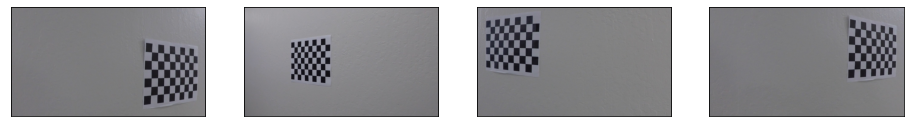

In [3]:
# Loading test images from test_image directory
camera_cal_imgs = [mpimg.imread(path) for path in glob.glob("camera_cal/*")]

# Visualize calibration images
show_images(camera_cal_imgs[:4], divider=4)

In [4]:
def grayscale(img, opencv_read=False):
    """

    :param img:
    :param opencv_read:
    :return:
    """
    if opencv_read:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [5]:
# prepare objects points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and iamg points from all the images
objpoints = []
imgpoints = []

In [6]:
def find_and_draw_chessboard(img, idx,axs, pattern_size= (9,6)):
    gray = grayscale(img)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, pattern_size, corners, ret)
        
        axs[idx].axis('off')
        axs[idx].imshow(img)

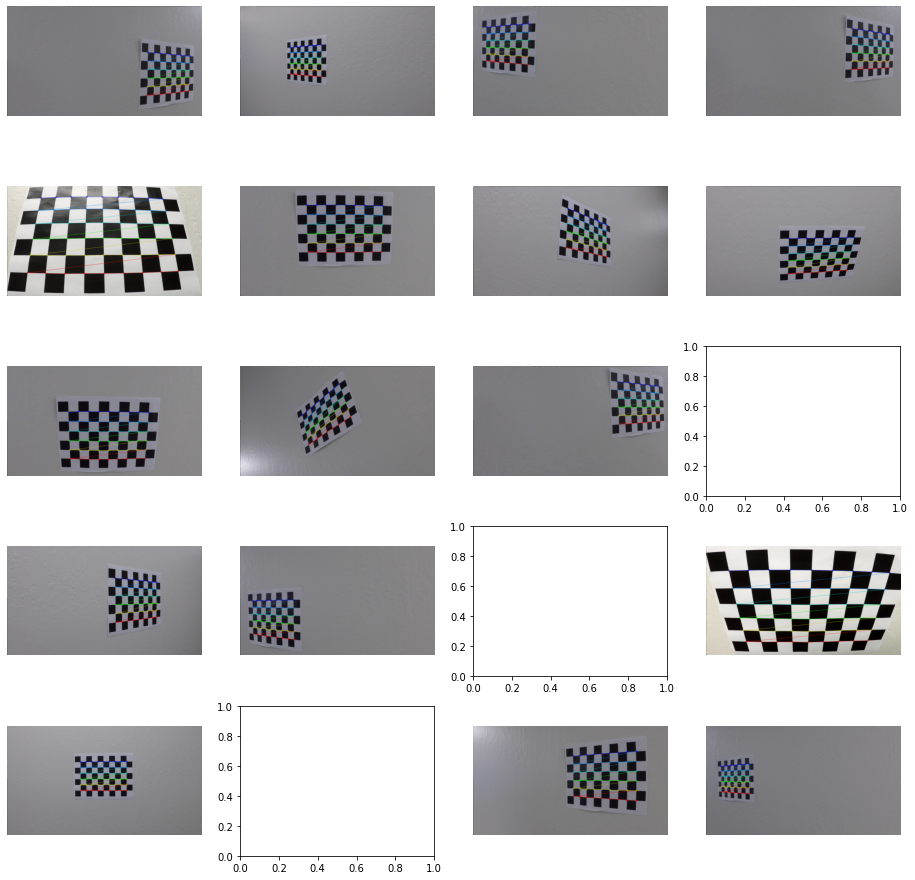

In [7]:
# Draw subplots dynamically
fig, axs = plt.subplots(5,4, figsize=(16, 16))
axs = axs.ravel()

for idx, img in enumerate(camera_cal_imgs):
    find_and_draw_chessboard(img,idx,axs)

### Calibrating Camera

In [8]:
#cache an image to further reuse
sample_img = mpimg.imread("camera_cal/calibration1.jpg")
#cache image size to further reuse
img_size = sample_img.shape[:2]

# Do Camera calibration given objects' points and images' points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)

# Save the Camera calibration results for later use
dist_pickle = {"mtx": mtx, "dist": dist}
pickle.dump( dist_pickle, open( "resources/calibration.p", "wb" ) )

### Undistort Images

In [9]:
def undistort(img, mtx, dist):
    """

    :param img:
    :param mtx:
    :param dist:
    :return:
    """
    return cv2.undistort(img, mtx, dist,None, mtx)

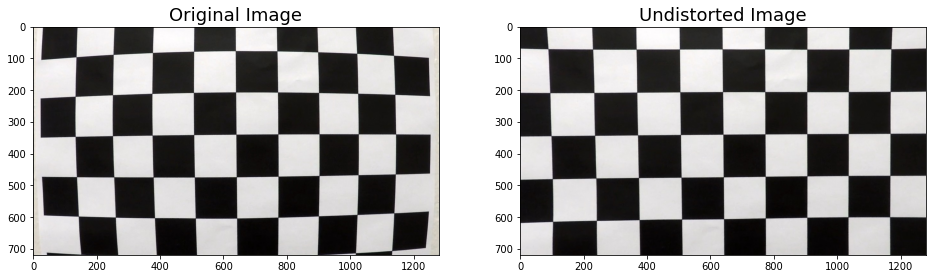

In [10]:
def undistort_image(img, cmatrix, distc ):
    """

    :param sample_img:
    :param cmatrix:
    :param distc:
    :return:
    """
    udistord_img = undistort(img, cmatrix, distc)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(udistord_img)
    ax2.set_title('Undistorted Image', fontsize=18)
    # this can be used
    return udistord_img

res = undistort_image(sample_img, mtx,dist)

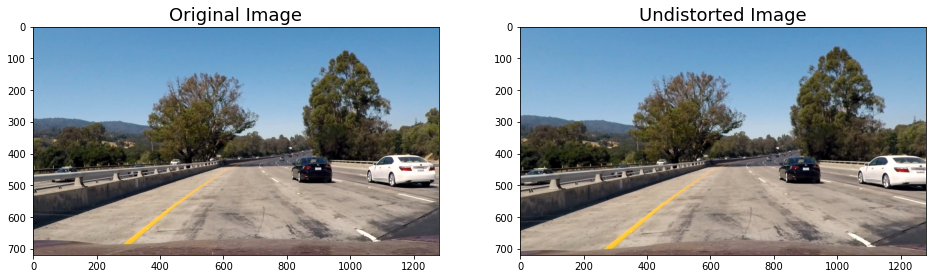

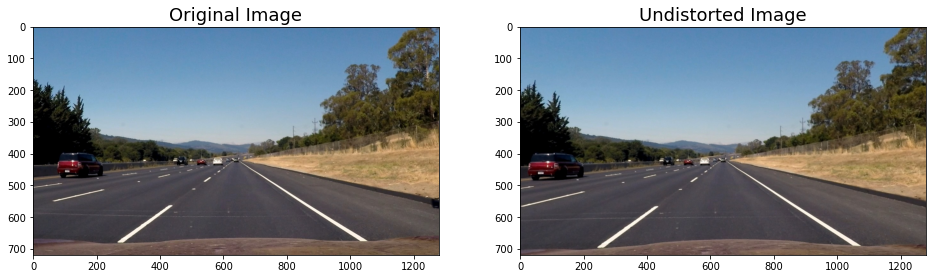

In [11]:
test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

#undistord images
undistort_images = list(map(lambda img: undistort_image(img, mtx, dist), test_images[:2]))

### Perspective Transform

In [12]:
def corners_unwarp(img, src, dst):
    """

    :param img: input image
    :param src: source
    :param dst: destination
    :return:
    """
    M = cv2.getPerspectiveTransform(src,dst) # magnitute
    Minv = cv2.getPerspectiveTransform(dst, src)
    h,w = img.shape[:2]
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped, Minv, M

#### Select source and destination from images

In [13]:
height, width = test_images[0].shape[:2]
# source points
p1 = (575, 465)
p2 = (705, 465)
p3 = (255, 685)
p4 = (1050, 685)
line_color = (0, 255, 0) # Green

# destination points
pd1 = (450, 0)
pd2 = (width - 450, 0)
pd3 = (450, height)
pd4 = (width - 450, height)

In [14]:
def draw_polygon_on_image(img, line_color=(0, 255,0)):
    """

    :param img:
    :return:
    """
    cv2.line(img, p1, p2, line_color, 3)
    cv2.line(img, p2, p4, line_color, 3)
    cv2.line(img, p4, p3, line_color, 3)
    cv2.line(img, p3, p1, line_color, 3)

    return  img

#### Warped source images before warp


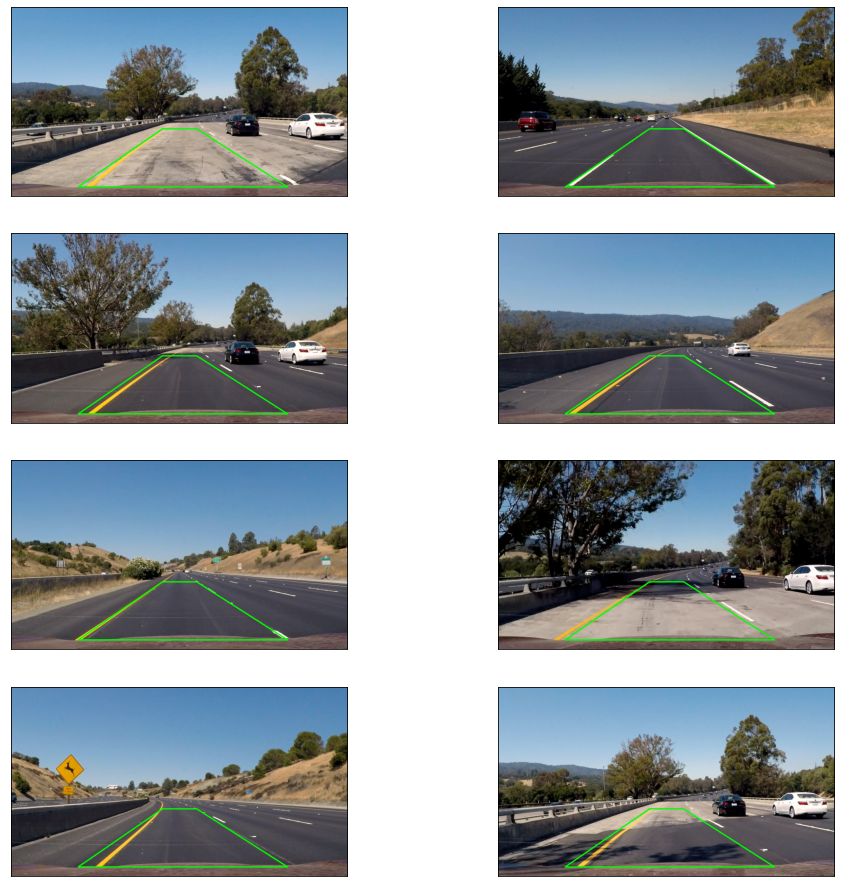

In [15]:
src_selected_images = list(map(lambda img: draw_polygon_on_image(img), test_images))
show_images(src_selected_images)

In [16]:
def visualize_warped_images(img, src, dst):
    unwarped, _, _ = corners_unwarp(img, src, dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    img = draw_polygon_on_image(img)
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=18)
    ax2.imshow(unwarped)
    ax2.set_title('Unwarped Image', fontsize=18)
    return unwarped

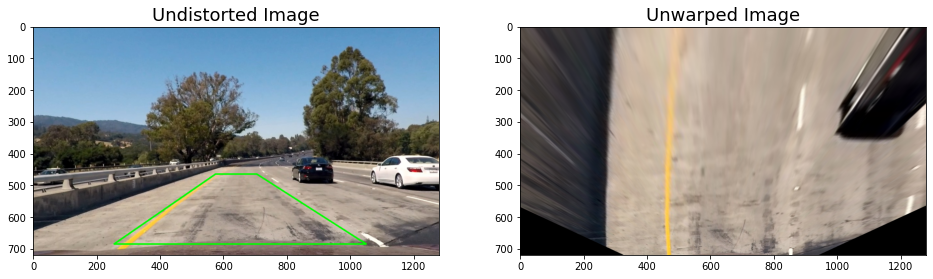

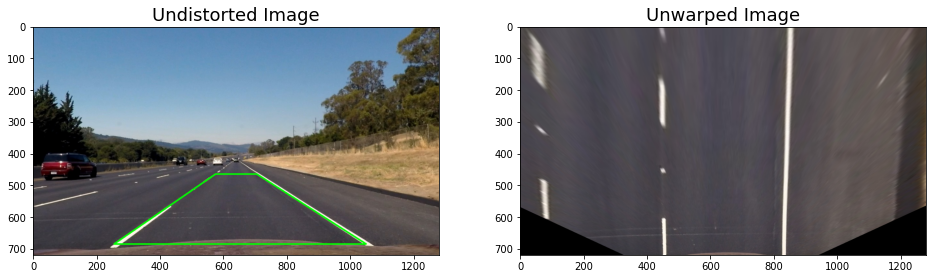

In [17]:
# define source and destination points for tranform
src = np.float32([p1, p2, p3, p4])
dst = np.float32([pd1, pd2, pd3, pd4])
#
warped_images = list(map(lambda img: visualize_warped_images(img, src, dst), undistort_images))

#### Colour channels

In [18]:
def extract_rgb_color_spaces(uwimg):
    unwarp_R = uwimg[:, :, 0]
    unwarp_G = uwimg[:, :, 1]
    unwarp_B = uwimg[:, :, 2]
    
    return unwarp_R,unwarp_G,unwarp_B

def extract_hsv_color_spaces(uwimg):
    unwarp_HSV = cv2.cvtColor(uwimg, cv2.COLOR_RGB2HSV)
    unwarp_H = unwarp_HSV[:, :, 0]
    unwarp_S = unwarp_HSV[:, :, 1]
    unwarp_V = unwarp_HSV[:, :, 2]
    
    return unwarp_H,unwarp_S,unwarp_V

def extract_hsl_color_spaces(uwimg):
    unwarp_HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    unwarp_HSL_H = unwarp_HSL[:, :, 0]
    unwarp_HSL_S = unwarp_HSL[:, :, 1]
    unwarp_HSL_L = unwarp_HSL[:, :, 2]
    
    return unwarp_HSL_H,unwarp_HSL_S,unwarp_HSL_L

def extract_lab_color_spaces(uwimg):
    unwarped_LAB = cv2.cvtColor(uwimg, cv2.COLOR_RGB2Lab)
    unwarp_L = unwarped_LAB[:,:,0]
    unwarp_A = unwarped_LAB[:,:,1]
    unwarp_B = unwarped_LAB[:,:,2]
    
    return unwarp_L, unwarp_A,unwarp_B

In [19]:
def apply_rgb_filter(unwarp_img):
    #RGB
    unwarp_R,unwarp_G ,unwarp_B = extract_rgb_color_spaces(unwarp_img)
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(unwarp_R, cmap='gray')
    axs[0].set_title('RGB R-channel', fontsize=12)
    axs[1].imshow(unwarp_G, cmap='gray')
    axs[1].set_title('RGB G-Channel', fontsize=12)
    axs[2].imshow(unwarp_B, cmap='gray')
    axs[2].set_title('RGB B-channel', fontsize=12)

    
def apply_hsv_filter(unwarp_img):
    # HSV
    unwarp_H,unwarp_S,unwarp_V = extract_hsv_color_spaces(unwarp_img)
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    
    axs[0].imshow(unwarp_H, cmap='gray')
    axs[0].set_title('HSV H-Channel', fontsize=12)
    axs[1].imshow(unwarp_S, cmap='gray')
    axs[1].set_title('HSV S-channel', fontsize=12)
    axs[2].imshow(unwarp_V, cmap='gray')
    axs[2].set_title('HSV V-Channel', fontsize=12)
    
def apply_hsl_filter(unwarp_img):
     # HSL
    unwarp_HSL_H,unwarp_HSL_S,unwarp_HSL_L = extract_hsl_color_spaces(unwarp_img)
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(unwarp_HSL_H, cmap='gray')
    axs[0].set_title('HSL H-Channel', fontsize=12)
    axs[1].imshow(unwarp_HSL_S, cmap='gray')
    axs[1].set_title('HSL S-channel', fontsize=12)
    axs[2].imshow(unwarp_HSL_L, cmap='gray')
    axs[2].set_title('HSL V-Channel', fontsize=12)
    
def apply_lab_filter(unwarp_img):
    # LAB
    unwarp_L, unwarp_A,unwarp_B = extract_lab_color_spaces(unwarp_img)
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(unwarp_L, cmap='gray')
    axs[0].set_title('LAB L-Channel', fontsize=12)
    axs[1].imshow(unwarp_A, cmap='gray')
    axs[1].set_title('LAB A-channel', fontsize=12)
    axs[2].imshow(unwarp_B, cmap='gray')
    axs[2].set_title('LAB L-Channel', fontsize=12)

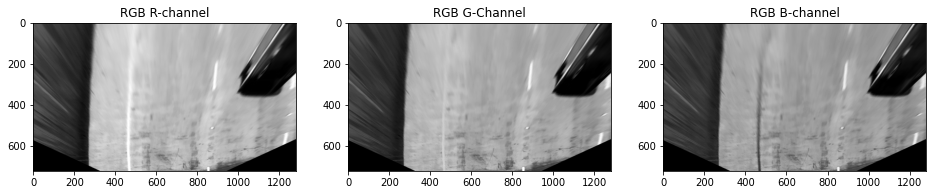

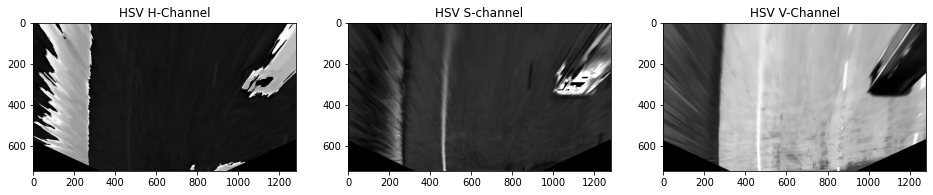

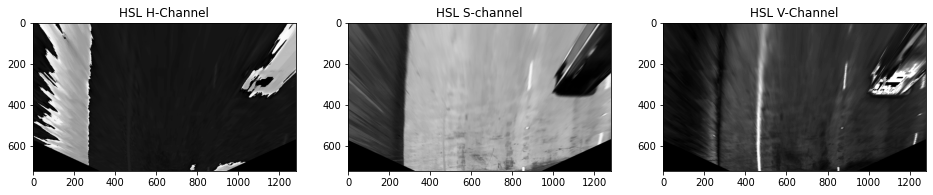

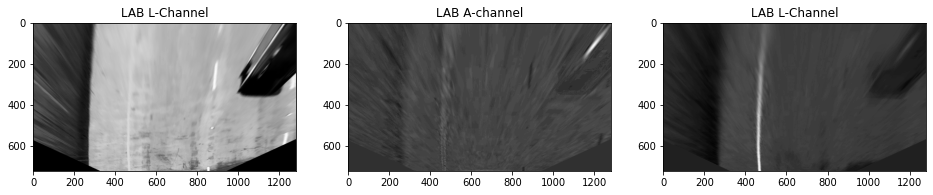

In [20]:
def apply_color_filter(unwarp_img):
    apply_rgb_filter(unwarp_img)
    apply_hsv_filter(unwarp_img)
    apply_hsl_filter(unwarp_img)
    apply_lab_filter(unwarp_img)
    
for img in warped_images[:1]:
    apply_color_filter(img)


####  Sobel Thresolding


In [25]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
#     gray = grayscale(img)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    dx = 1 if orient=='x'  else  0
    dy = 1 if orient=='y'  else  0

    sobel = cv2.Sobel(gray, cv2.CV_64F,dx ,dy)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_sobel

In [33]:
def apply_sobel_threshold(img, gray, min_thresh, max_thresh):
    """
    :param unwarp_img:
    :param min_thresh:
    :param max_thresh:
    :return:
    """
    abs_sobel = abs_sobel_thresh(gray, 'x', min_thresh, max_thresh)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
    ax1.imshow(img)
    ax1.set_title('Unwarped Image', fontsize=18)
    ax2.imshow(abs_sobel, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=18)
    plt.show()

In [34]:
### Test with different colour spaces

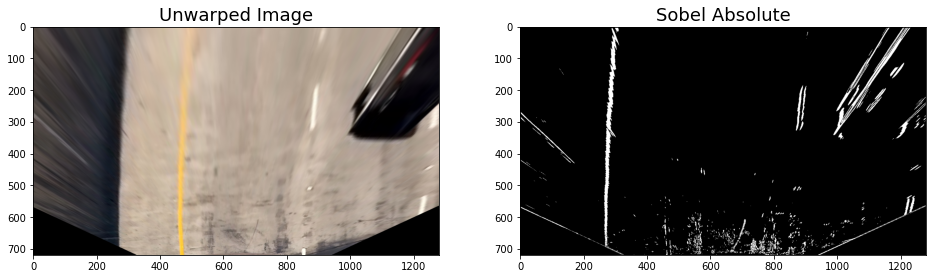

In [38]:
min_thresh=20
max_thresh=100

sample_img = warped_images[0]
gray = grayscale(sample_img)
apply_sobel_threshold(sample_img,gray,min_thresh, max_thresh)


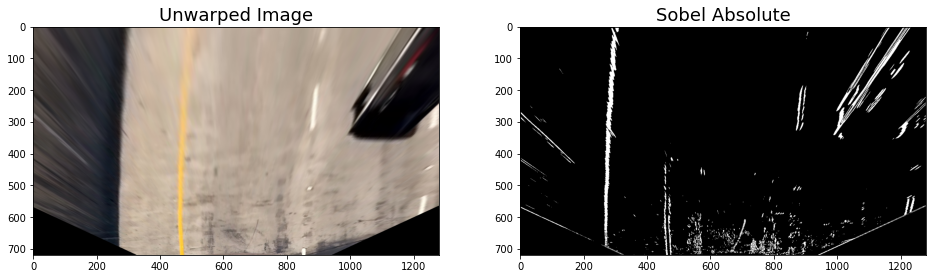

In [39]:

sample_img = warped_images[0]
gray_rgb,_,_ = extract_rgb_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_rgb,min_thresh, max_thresh)


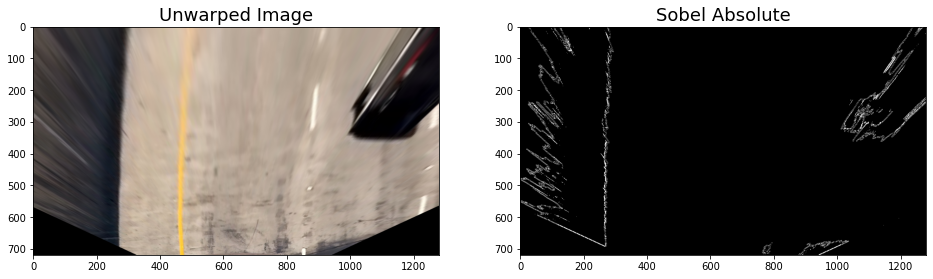

In [40]:

sample_img = warped_images[0]
gray_hsv,_,_ = extract_hsv_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_hsv,min_thresh, max_thresh)


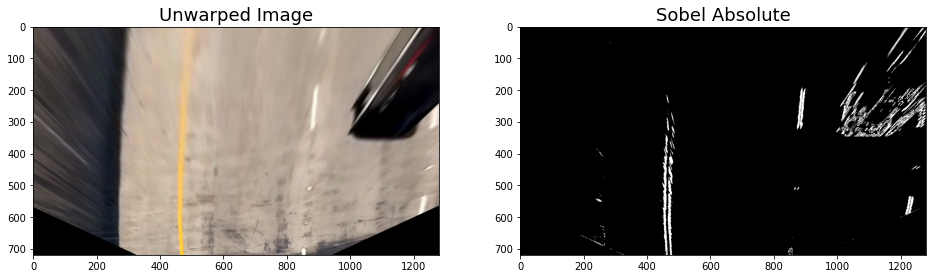

In [41]:

sample_img = warped_images[0]
_,_,gray_hsl = extract_hsl_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_hsl,min_thresh, max_thresh)


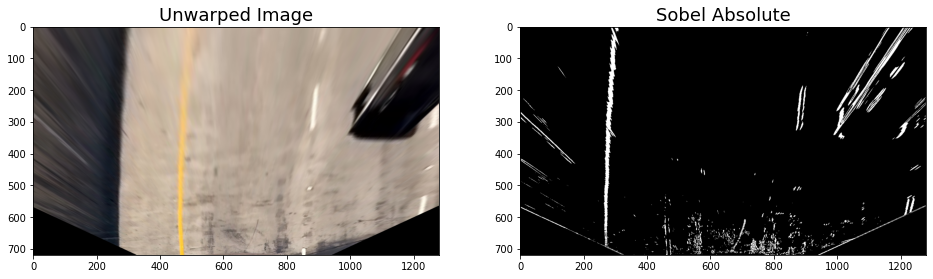

In [42]:

sample_img = warped_images[0]
gray_lab,_,_ = extract_lab_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_lab,min_thresh, max_thresh)

In [ ]:


for um_warped_img in warped_images:
    apply_sobel_threshold(um_warped_img, min_thresh, max_thresh)

#### Magnitude of the gradient

In [ ]:
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = grayscale(img) # extract HSL L color scpace
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [ ]:
def apply_sobel_mag_gradient(uwimg,sobel_kernel, min_thresh, max_thresh):
    
    sobel_mag = mag_threshold(img, sobel_kernel,(min_thresh, max_thresh))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(uwimg)
    ax1.set_title('Unwarped Image', fontsize=18)
    ax2.imshow(sobel_mag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=18)

In [ ]:
min_thresh=20
max_thresh=100
sobel_kernel = 3
for img in warped_images:
    apply_sobel_mag_gradient(img,sobel_kernel, min_thresh, max_thresh)

#### Direction of the gradient

In [ ]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = grayscale(img) # extract HSL L color scpace
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [ ]:
def apply_sobel_dir_gradient(uwimg,sobel_kernel, min_thresh, max_thresh):
    
    sobel_mag = dir_threshold(img, sobel_kernel,(min_thresh, max_thresh))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(uwimg)
    ax1.set_title('Unwarped Image', fontsize=18)
    ax2.imshow(sobel_mag, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=18)

In [ ]:
min_thresh=0.7
max_thresh=1.3
sobel_kernel = 15
for img in warped_images[:1]:
    apply_sobel_dir_gradient(img,sobel_kernel, min_thresh, max_thresh)

#### Sobel Magnitude and Direction

In [ ]:
def combine_thresholds(unwarp_img, mag_kernel, mag_thresh, dir_thresh, dir_kernel ):
    sobel_mag = mag_threshold(unwarp_img, mag_kernel,mag_thresh)
    sobel_dir = dir_threshold(unwarp_img, dir_kernel, dir_thresh)
    
    combined = np.zeros_like(sobel_mag)
    combined[((sobel_mag == 1) & (sobel_dir == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    
    ax1.imshow(unwarp_img)
    ax1.set_title('Unwarped Image', fontsize=18)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=18)

In [ ]:
mag_thresh = (20, 100)
dir_thresh = (0.7, 1.3)
mag_kernel = 15
dir_kernel = 15

for img in warped_images[:3]:
    combine_thresholds(img, mag_kernel, mag_thresh, dir_thresh, dir_kernel)

In [ ]:
# Download IPython notebook as HTML file
import os
os.system('jupyter nbconvert --to html Advanced_Lane_Finding.ipynb')
